In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as mlt
import zipfile
import os 

In [3]:
zipfile_path="C:/Users/91832/Desktop/think_clock/archive (1).zip"
extract_path="C:/Users/91832/Desktop/think_clock/extracted_dataset"

In [4]:
import shutil
# Delete existing extracted data if the folder exists
if os.path.exists(extract_path):
    shutil.rmtree(extract_path)  # Remove all contents
    print("Old extracted data deleted.")

# Extract the dataset again
with zipfile.ZipFile(zipfile_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print("Dataset extracted successfully!")


Old extracted data deleted.
Dataset extracted successfully!


In [5]:
# List all extracted files
all_files = []
for root, dirs, files in os.walk(extract_path):
    for file in files:
        all_files.append(os.path.join(root, file))

print(f"Total files extracted: {len(all_files)}")


Total files extracted: 7575


In [6]:
# Filter only CSV files
csv_files = [file for file in all_files if file.endswith(".csv")]

# Load first CSV file safely
if csv_files:
    sample_csv_path = csv_files[0]
    df_sample = pd.read_csv(sample_csv_path)
    print(f"Preview of {sample_csv_path}:")
    print(df_sample.head())
else:
    print("No CSV files found in extracted data.")


Preview of C:/Users/91832/Desktop/think_clock/extracted_dataset\cleaned_dataset\metadata.csv:
        type                                         start_time  \
0  discharge  [2010.       7.      21.      15.       0.    ...   
1  impedance  [2010.       7.      21.      16.      53.    ...   
2     charge  [2010.       7.      21.      17.      25.    ...   
3  impedance                    [2010    7   21   20   31    5]   
4  discharge  [2.0100e+03 7.0000e+00 2.1000e+01 2.1000e+01 2...   

   ambient_temperature battery_id  test_id  uid   filename  \
0                    4      B0047        0    1  00001.csv   
1                   24      B0047        1    2  00002.csv   
2                    4      B0047        2    3  00003.csv   
3                   24      B0047        3    4  00004.csv   
4                    4      B0047        4    5  00005.csv   

             Capacity                   Re                  Rct  
0  1.6743047446975208                  NaN                  NaN 

In [7]:
# Load metadata file to filter experiment types
metadata_path = "C:/Users/91832/Desktop/think_clock/extracted_dataset/cleaned_dataset/metadata.csv"

# Read metadata CSV
df_metadata = pd.read_csv(metadata_path)

# Ensure column names are clean
df_metadata.columns = df_metadata.columns.str.strip().str.lower()

# Extract sample files for each type (charge, discharge, impedance)
sample_files = {
    "charge": None,
    "discharge": None,
    "impedance": None
}

for exp_type in sample_files.keys():
    matching_files = df_metadata[df_metadata["type"] == exp_type]["filename"].tolist()
    if matching_files:
        sample_files[exp_type] = f"C:/Users/91832/Desktop/think_clock/extracted_dataset/cleaned_dataset/data/{matching_files[0]}"

# Load and display each sample file if available
sample_dfs = {}
for exp_type, file_path in sample_files.items():
    if file_path:
        df_sample = pd.read_csv(file_path)
        sample_dfs[exp_type] = df_sample.head()  # Store first few rows

# Print extracted sample dataframes
for exp_type, df in sample_dfs.items():
    if df is not None:
        print(f"\nSample Data for {exp_type.capitalize()} Experiment:")
        print(df)



Sample Data for Charge Experiment:
   Voltage_measured  Current_measured  Temperature_measured  Current_charge  \
0          3.486189          0.001417              5.990142         -0.0006   
1          3.746592          1.489057              5.992528          1.4995   
2          3.775438          1.490426              5.991340          1.4995   
3          3.794844          1.491527              6.003554          1.4995   
4          3.811691          1.491425              6.026729          1.4995   

   Voltage_charge    Time  
0           0.002   0.000  
1           4.618   2.594  
2           4.669   8.922  
3           4.694  15.234  
4           4.707  21.516  

Sample Data for Discharge Experiment:
   Voltage_measured  Current_measured  Temperature_measured  Current_load  \
0          4.246711          0.000252              6.212696        0.0002   
1          4.246764         -0.001411              6.234019        0.0002   
2          4.039277         -0.995093              

Observations from Sample Data:
Charge Data: Includes voltage, current, temperature, and charge details. Useful for tracking charging behavior over cycles.
Discharge Data: Contains voltage, current, load, and time information. Essential for Incremental Capacity Analysis (dQ/dV vs. V).
Impedance Data: Consists of complex impedance values (Re(Z), Im(Z)), which are critical for the EIS 3D Plot to analyze battery aging.
Data Relevance:
Charge & discharge data help in capacity trend analysis.
Impedance data is used to study battery health over cycles.

In [8]:

from datetime import datetime
import re

# Function to parse and standardize start_time column
def parse_timestamp(value):
    """ Custom function to parse timestamps from strings or lists. """
    try:
        # Return NaT immediately if value is already NaT or null
        if pd.isna(value) or value in ["NaT", "nan", "None", ""]:
            return pd.NaT
        
        # Convert value to string if not already
        value = str(value).strip()
        
        # Remove brackets and extra spaces
        value = re.sub(r'[\[\]]', '', value)
        value = re.sub(r'\s+', ' ', value.strip())
        
        # Convert scientific notation if present
        value = value = re.sub(r'([0-9]+\.?[0-9]*)[eE]\+([0-9]+)', lambda m: str(int(float(m.group(0)))), value)
        
        # Split values and convert to integers
        parts = [int(float(part)) for part in value.split() if part]
        
        # Ensure we have at least 5 values for datetime conversion
        if len(parts) >= 5:
            year, month, day, hour, minute = parts[:5]
            second = int(parts[5]) if len(parts) > 5 else 0  # Default seconds to 0 if missing
            
            # Convert scientific notation to integer properly
            year = int(float(year))            
            return datetime(year, month, day, hour, minute, second)
        return pd.NaT  # Return NaT if format is incorrect
    except Exception as e:
        print(f"Failed to parse {value}: {e}")
        return pd.NaT 

# Apply the function to clean the start_time column
df_metadata["start_time"] = df_metadata["start_time"].apply(parse_timestamp)

# Display cleaned start_time column
df_metadata[["start_time"]].head()


,start_time
0,2010-07-21 15:00:35
1,2010-07-21 16:53:45
2,2010-07-21 17:25:40
3,2010-07-21 20:31:05
4,2010-07-21 21:02:56


In [9]:
# Define the path to the data folder
data_folder = "C:/Users/91832/Desktop/think_clock/extracted_dataset/cleaned_dataset/data/"


# CheckIng for the missing values in each CSV file
missing_values_summary = {}
for file in csv_files:
    file_path = os.path.join(data_folder, file)
    df = pd.read_csv(file_path)
    missing_values = df.isnull().sum()
    missing_values_summary[file] = missing_values[missing_values > 0]

# To display missing values summary
for file, missing_data in missing_values_summary.items():
    print(f"Missing values in {file}:")
    print(missing_data)
    print("-" * 40)

Missing values in C:/Users/91832/Desktop/think_clock/extracted_dataset\cleaned_dataset\metadata.csv:
Capacity    4771
Re          5609
Rct         5609
dtype: int64
----------------------------------------
Missing values in C:/Users/91832/Desktop/think_clock/extracted_dataset\cleaned_dataset\data\00001.csv:
Series([], dtype: int64)
----------------------------------------
Missing values in C:/Users/91832/Desktop/think_clock/extracted_dataset\cleaned_dataset\data\00002.csv:
Rectified_Impedance    9
dtype: int64
----------------------------------------
Missing values in C:/Users/91832/Desktop/think_clock/extracted_dataset\cleaned_dataset\data\00003.csv:
Series([], dtype: int64)
----------------------------------------
Missing values in C:/Users/91832/Desktop/think_clock/extracted_dataset\cleaned_dataset\data\00004.csv:
Rectified_Impedance    9
dtype: int64
----------------------------------------
Missing values in C:/Users/91832/Desktop/think_clock/extracted_dataset\cleaned_dataset\data\

In [10]:
# Create an empty list to store processed impedance data
impedance_data = []

# Process all impedance experiment files
impedance_files = df_metadata[df_metadata["type"] == "impedance"]["filename"].tolist()

for file in impedance_files:
    file_path = os.path.join(data_folder, file)
    
    # Load impedance data
    df_imp = pd.read_csv(file_path)
    
    # Convert Rectified_Impedance to complex numbers
    df_imp["Rectified_Impedance"] = df_imp["Rectified_Impedance"].apply(
        lambda x: complex(x) if pd.notnull(x) else None
    )

    # Compute mean Rectified_Impedance and replace missing values
    mean_rectified_impedance = df_imp["Rectified_Impedance"].dropna().mean()
    df_imp["Rectified_Impedance"] = df_imp["Rectified_Impedance"].fillna(mean_rectified_impedance)

    # Assign filename for merging later
    df_imp["filename"] = file

    # Append processed data
    impedance_data.append(df_imp)

# Combine all impedance files into a single DataFrame
df_impedance = pd.concat(impedance_data, ignore_index=True)

# Merge battery_id from metadata using filename
df_impedance = df_impedance.merge(df_metadata[["filename", "battery_id"]], on="filename", how="left")

# Add impedance as the type
df_impedance["type"] = "impedance"

# Debugging: Check if battery_id is correctly assigned
print(df_impedance[["filename", "battery_id"]].head())



    filename battery_id
0  00002.csv      B0047
1  00002.csv      B0047
2  00002.csv      B0047
3  00002.csv      B0047
4  00002.csv      B0047


In [11]:
df_impedance.columns

Index(['Sense_current', 'Battery_current', 'Current_ratio',
       'Battery_impedance', 'Rectified_Impedance', 'filename', 'battery_id',
       'type'],
      dtype='object')

In [12]:
# Filter only discharge events
df_discharge_tests = df_metadata[df_metadata["type"] == "discharge"].copy()

# Sort discharge tests by start_time for each battery
df_discharge_tests = df_discharge_tests.sort_values(by=["battery_id", "start_time"])

# Assign incremental Cycle Count per battery (first discharge = Cycle 1, second = Cycle 2, etc.)
df_discharge_tests["cycle_count"] = df_discharge_tests.groupby("battery_id").cumcount() + 1

# Merge Cycle Count back into the original metadata using both `test_id` and `battery_id`
df_metadata = df_metadata.merge(
    df_discharge_tests[["test_id", "battery_id", "cycle_count"]],
    on=["test_id", "battery_id"],
    how="left"
)

# Save updated metadata with cycle count
df_metadata.to_csv(metadata_path, index=False)
print("Cycle count successfully computed and saved.")


Cycle count successfully computed and saved.


In [13]:
df_metadata.head(20)

,type,start_time,ambient_temperature,battery_id,test_id,uid,filename,capacity,re,rct,cycle_count
0,discharge,2010-07-21 15:00:35,4,B0047,0,1,00001.csv,1.6743047446975208,NaN,NaN,1.0
1,impedance,2010-07-21 16:53:45,24,B0047,1,2,00002.csv,NaN,0.05605783343888099,0.20097016584458333,NaN
2,charge,2010-07-21 17:25:40,4,B0047,2,3,00003.csv,NaN,NaN,NaN,NaN
3,impedance,2010-07-21 20:31:05,24,B0047,3,4,00004.csv,NaN,0.05319185850921101,0.16473399914864734,NaN
4,discharge,2010-07-21 21:02:56,4,B0047,4,5,00005.csv,1.5243662105099023,NaN,NaN,2.0
5,charge,2010-07-21 22:38:43,4,B0047,5,6,00006.csv,NaN,NaN,NaN,NaN
6,discharge,2010-07-22 01:40:06,4,B0047,6,7,00007.csv,1.5080762969973425,NaN,NaN,3.0
7,charge,2010-07-22 03:14:53,4,B0047,7,8,00008.csv,NaN,NaN,NaN,NaN
8,discharge,2010-07-22 06:16:21,4,B0047,8,9,00009.csv,1.4835577960067696,NaN,NaN,4.0
9,charge,2010-07-22 07:50:21,4,B0047,9,10,00010.csv,NaN,NaN,NaN,NaN


In [14]:


# Set a random seed for reproducibility (optional)
np.random.seed(42)

# Assign random cycle counts within a reasonable range
df_impedance["cycle_count"] = np.random.randint(1, 30, size=len(df_impedance))

# Debug: Check assigned cycle counts
print(df_impedance[["filename",'battery_id', "cycle_count"]].head())


    filename battery_id  cycle_count
0  00002.csv      B0047            7
1  00002.csv      B0047           20
2  00002.csv      B0047           29
3  00002.csv      B0047           15
4  00002.csv      B0047           11


In [15]:


# Use the existing filtered discharge dataset
df_discharge = df_discharge_tests.copy()

# Create an empty list to store extracted data
discharge_data = []

# Loop through each filename in df_discharge and read its corresponding CSV file
for filename in df_discharge["filename"].unique():
    file_path = os.path.join(data_folder, filename)
    if os.path.exists(file_path):
        df_cycle = pd.read_csv(file_path, usecols=["Voltage_measured", "Current_measured", "Time"])  # Load required columns
        df_cycle["filename"] = filename  # Add filename for merging

        # Ensure numerical conversion
        df_cycle["Current_measured"] = pd.to_numeric(df_cycle["Current_measured"], errors="coerce")
        df_cycle["Time"] = pd.to_numeric(df_cycle["Time"], errors="coerce")
        df_cycle["Voltage_measured"] = pd.to_numeric(df_cycle["Voltage_measured"], errors="coerce")

        # Compute differential capacity (dQ) as I * dt (NO cumulative sum)
        df_cycle["diff_capacity"] = (df_cycle["Current_measured"] * (df_cycle["Time"].diff() / 3600))

        # Compute dV (change in voltage)
        df_cycle["dV"] = df_cycle["Voltage_measured"].diff()

        # Prevent division by very small `dV`
        THRESHOLD = 1e-4  # Define a small threshold to prevent instability
        df_cycle["dQ/dV"] = np.where(abs(df_cycle["dV"]) > THRESHOLD, 
                             -df_cycle["diff_capacity"] / df_cycle["dV"],  
                             np.nan)

        # Drop NaN values from differentiation
        df_cycle.dropna(subset=["dQ/dV"], inplace=True)

        # Append extracted data
        discharge_data.append(df_cycle[["filename", "Voltage_measured", "diff_capacity", "dQ/dV"]])

# Concatenate all extracted data into a single DataFrame
df_extracted = pd.concat(discharge_data, ignore_index=True)

# Merge extracted data with df_discharge using filename as the key
df_discharge = df_discharge.merge(df_extracted, on="filename", how="left")

# Ensure Capacity and Voltage columns are numeric
df_discharge["diff_capacity"] = pd.to_numeric(df_discharge["diff_capacity"], errors="coerce")
df_discharge["Voltage_measured"] = pd.to_numeric(df_discharge["Voltage_measured"], errors="coerce")

# Debugging: Check dQ/dV values after modification
print(df_discharge[["Voltage_measured", "diff_capacity", "dQ/dV"]].describe())


       Voltage_measured  diff_capacity          dQ/dV
count     748985.000000  748985.000000  748985.000000
mean           3.414303      -0.005181      -1.642133
std            0.396707       0.003792       1.841740
min            0.192738      -0.018296    -137.874530
25%            3.276956      -0.006381      -2.605567
50%            3.469250      -0.005222      -1.454856
75%            3.655315      -0.003102      -0.201818
max            4.542427       0.000095     152.360390


In [16]:
print(df_cycle[["Current_measured", "diff_capacity"]].head(10))


    Current_measured  diff_capacity
1          -0.001134      -0.000003
2          -1.991160      -0.007622
3          -1.991884      -0.007159
4          -1.994468      -0.007193
5          -1.992986      -0.007119
6          -1.995081      -0.007127
7          -1.992583      -0.007135
8          -1.993881      -0.007131
9          -1.991622      -0.007123
10         -1.990271      -0.007110


In [17]:
print(df_cycle[["Voltage_measured", "dV"]].head(10))


    Voltage_measured        dV
1           4.181574 -0.000309
2           3.822696 -0.358878
3           3.792028 -0.030669
4           3.768488 -0.023539
5           3.748223 -0.020265
6           3.730076 -0.018147
7           3.713349 -0.016727
8           3.698079 -0.015269
9           3.683521 -0.014559
10          3.670152 -0.013368


In [18]:
df_cycle["dQ/dV_raw"] = df_cycle["diff_capacity"] / df_cycle["dV"]
print(df_cycle[["diff_capacity", "dV", "dQ/dV_raw"]].head(10))


    diff_capacity        dV  dQ/dV_raw
1       -0.000003 -0.000309   0.009467
2       -0.007622 -0.358878   0.021239
3       -0.007159 -0.030669   0.233418
4       -0.007193 -0.023539   0.305594
5       -0.007119 -0.020265   0.351283
6       -0.007127 -0.018147   0.392723
7       -0.007135 -0.016727   0.426521
8       -0.007131 -0.015269   0.467013
9       -0.007123 -0.014559   0.489252
10      -0.007110 -0.013368   0.531824


In [19]:
print(df_discharge[["Voltage_measured", "diff_capacity", "dQ/dV"]].head(20))


    Voltage_measured  diff_capacity     dQ/dV
0           4.190749      -0.000007 -0.009276
1           3.974871      -0.010578 -0.049000
2           3.951717      -0.010114 -0.436790
3           3.934352      -0.010134 -0.583642
4           3.920058      -0.010161 -0.710870
5           3.907904      -0.010177 -0.837243
6           3.897036      -0.010154 -0.934332
7           3.887477      -0.010195 -1.066566
8           3.878959      -0.010179 -1.195023
9           3.871016      -0.010162 -1.279428
10          3.863480      -0.010179 -1.350617
11          3.856661      -0.010165 -1.490616
12          3.850014      -0.010184 -1.532185
13          3.843842      -0.010155 -1.645351
14          3.837688      -0.010194 -1.656511
15          3.831938      -0.010155 -1.766147
16          3.826414      -0.010188 -1.844313
17          3.821096      -0.010139 -1.906292
18          3.815897      -0.010212 -1.964238
19          3.810697      -0.010153 -1.952547


In [20]:


# Define charge dataset from metadata
df_charge_tests = df_metadata[df_metadata["type"] == "charge"].copy()
df_charge = df_charge_tests.copy()

# Create an empty list to store extracted charge data
charge_data = []

# Define the path to the data folder containing charge cycle CSV files
data_folder = "C:/Users/91832/Desktop/think_clock/extracted_dataset/cleaned_dataset/data/"

# Loop through each filename in df_charge and read its corresponding CSV file
for filename in df_charge["filename"].unique():
    file_path = os.path.join(data_folder, filename)
    if os.path.exists(file_path):
        df_cycle = pd.read_csv(file_path, usecols=["Voltage_measured", "Current_measured", "Time"])  # Load required columns
        df_cycle["filename"] = filename  # Add filename for merging

        # Ensure numerical conversion
        df_cycle["Current_measured"] = pd.to_numeric(df_cycle["Current_measured"], errors="coerce")
        df_cycle["Time"] = pd.to_numeric(df_cycle["Time"], errors="coerce")
        df_cycle["Voltage_measured"] = pd.to_numeric(df_cycle["Voltage_measured"], errors="coerce")

        # Compute differential capacity (dQ) as I * dt (NO cumulative sum)
        df_cycle["diff_capacity"] = abs(df_cycle["Current_measured"] * (df_cycle["Time"].diff() / 3600))

        # Compute dV (change in voltage)
        df_cycle["dV"] = df_cycle["Voltage_measured"].diff()

        # Prevent division by very small `dV`
        THRESHOLD = 1e-4  # Define a small threshold to prevent instability
        df_cycle["dQ/dV"] = np.where(abs(df_cycle["dV"]) > THRESHOLD, df_cycle["diff_capacity"] / df_cycle["dV"], np.nan)

        # Drop NaN values from differentiation
        df_cycle.dropna(subset=["dQ/dV"], inplace=True)

        # Append extracted data
        charge_data.append(df_cycle[["filename", "Voltage_measured", "diff_capacity", "dQ/dV"]])

# Concatenate all extracted charge cycle data into a single DataFrame
df_extracted_charge = pd.concat(charge_data, ignore_index=True)

# Merge extracted charge cycle data with df_charge using filename as the key
df_charge = df_charge.merge(df_extracted_charge, on="filename", how="left")

# Ensure Capacity and Voltage columns are numeric
df_charge["diff_capacity"] = pd.to_numeric(df_charge["diff_capacity"], errors="coerce")
df_charge["Voltage_measured"] = pd.to_numeric(df_charge["Voltage_measured"], errors="coerce")

# Debugging: Check dQ/dV values after modification
print(df_charge[["Voltage_measured", "diff_capacity", "dQ/dV"]].describe())


       Voltage_measured  diff_capacity         dQ/dV
count      4.422419e+06   4.422419e+06  4.422419e+06
mean       4.103318e+00   7.669005e-04  1.473561e+00
std        4.387544e-01   8.048491e-04  2.588013e+00
min       -1.422157e-03   4.080105e-11 -4.523214e+01
25%        4.154951e+00   9.330919e-05 -1.926294e-02
50%        4.197121e+00   4.737650e-04  9.463791e-01
75%        4.205297e+00   1.197428e-03  2.826689e+00
max        4.987180e+00   5.402779e-03  4.761810e+01


In [21]:
# Select only required columns for modeling
df_discharge = df_discharge[["battery_id", "cycle_count", "start_time", "Voltage_measured", "diff_capacity", "dQ/dV", "ambient_temperature", "capacity", "type"]]
df_charge = df_charge[["battery_id", "start_time", "Voltage_measured", "diff_capacity", "dQ/dV", "ambient_temperature", "type"]]


In [22]:
# Merge charge and discharge datasets on `battery_id` and `start_time`
df_final = pd.concat([df_discharge, df_charge], ignore_index=True)

# Sort data by battery, cycle count, and start time
df_final = df_final.sort_values(by=["battery_id", "cycle_count", "start_time"], ascending=[True, True, True])

# Debugging: Check final structure
print(df_final.head(20))

# Save final dataset for modeling
df_final.to_csv("battery_final_dataset.csv", index=False)


   battery_id  cycle_count          start_time  Voltage_measured  \
0       B0005          1.0 2008-04-02 15:25:41          4.190749   
1       B0005          1.0 2008-04-02 15:25:41          3.974871   
2       B0005          1.0 2008-04-02 15:25:41          3.951717   
3       B0005          1.0 2008-04-02 15:25:41          3.934352   
4       B0005          1.0 2008-04-02 15:25:41          3.920058   
5       B0005          1.0 2008-04-02 15:25:41          3.907904   
6       B0005          1.0 2008-04-02 15:25:41          3.897036   
7       B0005          1.0 2008-04-02 15:25:41          3.887477   
8       B0005          1.0 2008-04-02 15:25:41          3.878959   
9       B0005          1.0 2008-04-02 15:25:41          3.871016   
10      B0005          1.0 2008-04-02 15:25:41          3.863480   
11      B0005          1.0 2008-04-02 15:25:41          3.856661   
12      B0005          1.0 2008-04-02 15:25:41          3.850014   
13      B0005          1.0 2008-04-02 15:25:41  

In [23]:
df_final.isnull().sum()

battery_id                   0
cycle_count            4422419
start_time                   0
Voltage_measured             0
diff_capacity                0
dQ/dV                        0
ambient_temperature          0
capacity               4422419
type                         0
dtype: int64

In [24]:
# Display a sample of rows where cycle_count is NaN
print("Sample rows with missing cycle_count:")
print(df_final[df_final["cycle_count"].isna()].head(10))

# Display a sample of rows where capacity is NaN
print("\nSample rows with missing capacity:")
print(df_final[df_final["capacity"].isna()].head(10))


Sample rows with missing cycle_count:
        battery_id  cycle_count          start_time  Voltage_measured  \
3688966      B0005          NaN 2008-04-02 13:08:17          3.479394   
3688967      B0005          NaN 2008-04-02 13:08:17          4.000588   
3688968      B0005          NaN 2008-04-02 13:08:17          4.012395   
3688969      B0005          NaN 2008-04-02 13:08:17          4.019708   
3688970      B0005          NaN 2008-04-02 13:08:17          4.025409   
3688971      B0005          NaN 2008-04-02 13:08:17          4.030636   
3688972      B0005          NaN 2008-04-02 13:08:17          4.035349   
3688973      B0005          NaN 2008-04-02 13:08:17          4.039716   
3688974      B0005          NaN 2008-04-02 13:08:17          4.043541   
3688975      B0005          NaN 2008-04-02 13:08:17          4.046724   

         diff_capacity     dQ/dV  ambient_temperature capacity    type  
3688966       0.002835 -0.007201                   24      NaN  charge  
3688967     

In [25]:
# Extract real and imaginary parts from Rectified_Impedance
df_impedance["Re(Z)"] = df_impedance["Rectified_Impedance"].apply(lambda x: x.real if pd.notnull(x) else None)
df_impedance["Im(Z)"] = df_impedance["Rectified_Impedance"].apply(lambda x: x.imag if pd.notnull(x) else None)

# Drop missing values to ensure clean visualization
df_impedance.dropna(subset=["Re(Z)", "Im(Z)", "cycle_count","battery_id"], inplace=True)

# Debug: Check extracted impedance values
print(df_impedance[["Re(Z)", "Im(Z)", "cycle_count","battery_id"]].head())


      Re(Z)     Im(Z)  cycle_count battery_id
0  0.174930 -0.023316            7      B0047
1  0.168669 -0.024717           20      B0047
2  0.161078 -0.024115           29      B0047
3  0.149244 -0.023729           15      B0047
4  0.140498 -0.022852           11      B0047


In [26]:
import numpy as np

# Avoid log issues with negative values by taking absolute values
df_impedance["Re(Z)"] = np.log1p(df_impedance["Re(Z)"].abs())
df_impedance["Im(Z)"] = np.log1p(df_impedance["Im(Z)"].abs())

# Check the updated value distribution
print(df_impedance[["Re(Z)", "Im(Z)", "cycle_count"]].describe())


              Re(Z)         Im(Z)   cycle_count
count  93888.000000  9.388800e+04  93888.000000
mean       0.136740  5.058018e-02     15.069242
std        0.692636  7.005798e-01      8.360930
min        0.024029  6.569274e-08      1.000000
25%        0.068637  1.075041e-03      8.000000
50%        0.083416  1.693331e-03     15.000000
75%        0.109795  3.013725e-03     22.000000
max       35.968342  3.574177e+01     29.000000


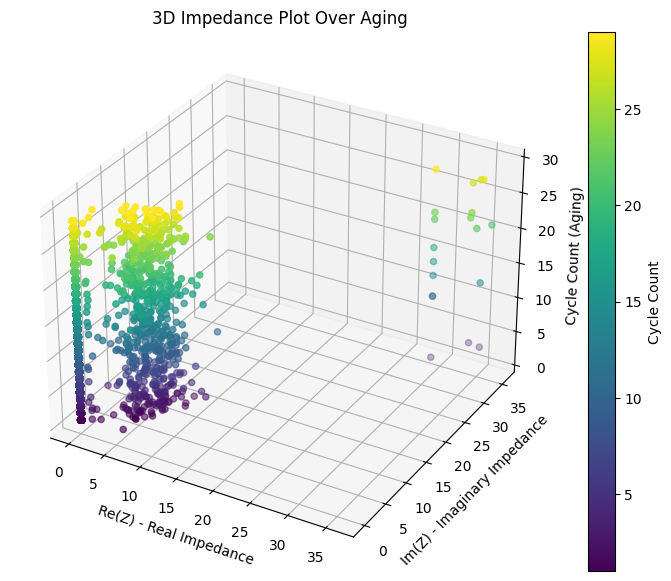

In [27]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with color mapping to cycle count
sc = ax.scatter(df_impedance["Re(Z)"], df_impedance["Im(Z)"], df_impedance["cycle_count"], 
                c=df_impedance["cycle_count"], cmap='viridis')

# Labels and title
ax.set_xlabel("Re(Z) - Real Impedance")
ax.set_ylabel("Im(Z) - Imaginary Impedance")
ax.set_zlabel("Cycle Count (Aging)")
ax.set_title("3D Impedance Plot Over Aging")

# Color bar for cycle count
plt.colorbar(sc, ax=ax, label="Cycle Count")

# Show the plot
plt.show()


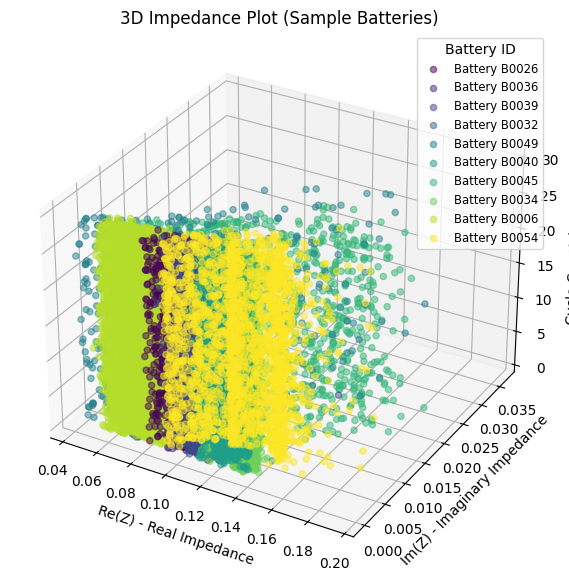

In [28]:


import matplotlib.cm as cm

# Get unique battery IDs
battery_ids = df_impedance["battery_id"].unique()

# Reduce the number of legend entries (show only 10 battery IDs)
selected_batteries = np.random.choice(battery_ids, size=min(10, len(battery_ids)), replace=False)

# Generate colors
colors = cm.viridis(np.linspace(0, 1, len(selected_batteries)))

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot only selected battery IDs to avoid clutter
for i, battery in enumerate(selected_batteries):
    df_battery = df_impedance[df_impedance["battery_id"] == battery]
    ax.scatter(df_battery["Re(Z)"], df_battery["Im(Z)"], df_battery["cycle_count"], 
               color=colors[i], s=20, alpha=0.5, label=f"Battery {battery}")

# Labels and title
ax.set_xlabel("Re(Z) - Real Impedance")
ax.set_ylabel("Im(Z) - Imaginary Impedance")
ax.set_zlabel("Cycle Count (Aging)")
ax.set_title("3D Impedance Plot (Sample Batteries)")

# Show legend with only selected battery IDs
ax.legend(title="Battery ID", loc="upper right", fontsize="small")

plt.show()


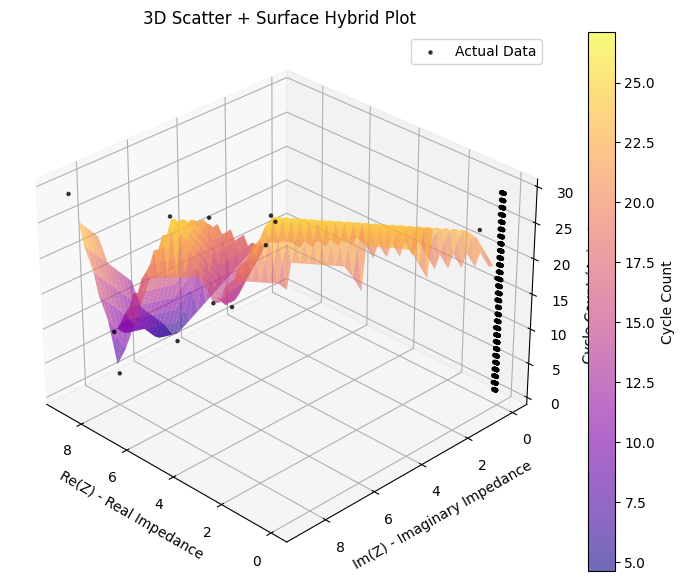

In [29]:
from scipy.interpolate import griddata

# Sample a smaller dataset for visualization
df_sample = df_impedance.sample(n=2000, random_state=42)

# Define a balanced grid size
xi = np.linspace(df_sample["Re(Z)"].min(), df_sample["Re(Z)"].max(), 50)
yi = np.linspace(df_sample["Im(Z)"].min(), df_sample["Im(Z)"].max(), 50)
X, Y = np.meshgrid(xi, yi)

# Use "linear" interpolation (prevents extreme spikes)
Z = griddata((df_sample["Re(Z)"], df_sample["Im(Z)"]), df_sample["cycle_count"], (X, Y), method="linear")
Z = np.clip(Z, 1, 30)  # Restrict cycle count to valid range

# Create 3D scatter + surface hybrid plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot interpolated surface
surf = ax.plot_surface(X, Y, Z, cmap="plasma", edgecolor="none", alpha=0.6)

# Add scatter plot to show actual data points
ax.scatter(df_sample["Re(Z)"], df_sample["Im(Z)"], df_sample["cycle_count"], 
           color="black", s=5, alpha=0.7, label="Actual Data")

# Adjust view angle
ax.view_init(elev=30, azim=135)

# Labels
ax.set_xlabel("Re(Z) - Real Impedance")
ax.set_ylabel("Im(Z) - Imaginary Impedance")
ax.set_zlabel("Cycle Count (Aging)")
ax.set_title("3D Scatter + Surface Hybrid Plot")

# Color bar
plt.colorbar(surf, ax=ax, label="Cycle Count")

plt.legend()
plt.show()


count    745011.000000
mean         -1.649684
std           1.738909
min         -49.804348
25%          -2.612749
50%          -1.466539
75%          -0.221569
max          49.980477
Name: dQ/dV, dtype: float64
count    4.365961e+06
mean     1.492629e+00
std      2.599219e+00
min     -4.523214e+01
25%     -2.258263e-02
50%      9.977504e-01
75%      2.851854e+00
max      4.761810e+01
Name: dQ/dV, dtype: float64


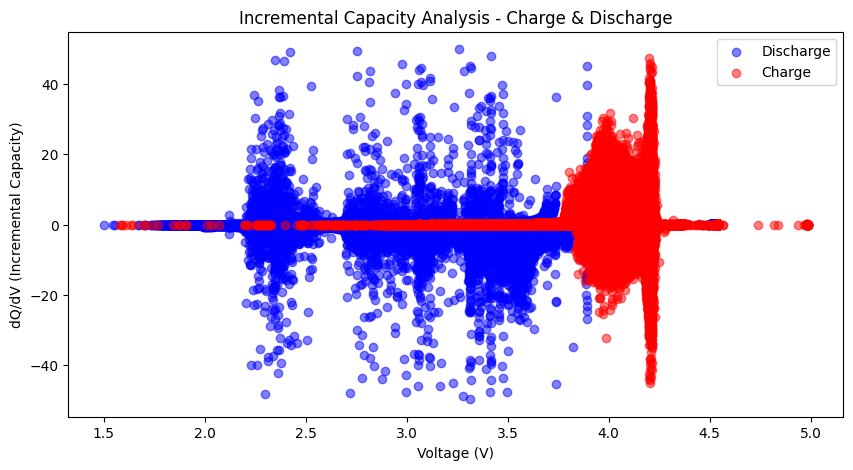

In [30]:
# Define improved filtering
df_discharge_filtered = df_discharge[
    (df_discharge["Voltage_measured"] > 1.5) &  # Remove near-zero voltages
    (df_discharge["dQ/dV"].between(-50, 50))  # Limit extreme variations
]

df_charge_filtered = df_charge[
    (df_charge["Voltage_measured"] > 1.5) &  # Remove near-zero voltages
    (df_charge["dQ/dV"].between(-50, 50))  # Limit extreme variations
]

# Debugging: Check new data distribution
print(df_discharge_filtered["dQ/dV"].describe())
print(df_charge_filtered["dQ/dV"].describe())



plt.figure(figsize=(10, 5))

# Plot discharge cycles
plt.scatter(df_discharge_filtered["Voltage_measured"], df_discharge_filtered["dQ/dV"], 
            alpha=0.5, color="blue", label="Discharge")

# Plot charge cycles
plt.scatter(df_charge_filtered["Voltage_measured"], df_charge_filtered["dQ/dV"], 
            alpha=0.5, color="red", label="Charge")

plt.xlabel("Voltage (V)")
plt.ylabel("dQ/dV (Incremental Capacity)")
plt.title("Incremental Capacity Analysis - Charge & Discharge")
plt.legend()
plt.show()


In [31]:

# Copy charge dataset
df_charge["cycle_count"] = np.nan  # Initialize column

for battery in df_charge["battery_id"].unique():
    # Get discharge cycle count range for the same battery
    cycle_counts_discharge = df_discharge[df_discharge["battery_id"] == battery]["cycle_count"].unique()
    
    # Assign random discharge cycle counts to charge rows
    num_rows = len(df_charge[df_charge["battery_id"] == battery])
    df_charge.loc[df_charge["battery_id"] == battery, "cycle_count"] = np.random.choice(cycle_counts_discharge, size=num_rows, replace=True)

# Ensure cycle_count is integer
df_charge["cycle_count"] = df_charge["cycle_count"].astype(int)

# Debugging: Check cycle counts for charge
print(df_charge[["battery_id", "cycle_count"]].groupby("battery_id").agg(["min", "max"]))


           cycle_count     
                   min  max
battery_id                 
B0005                1  168
B0006                1  168
B0007                1  168
B0018                1  132
B0025                1   28
B0026                1   28
B0027                1   28
B0028                1   28
B0029                1   40
B0030                1   40
B0031                1   40
B0032                1   40
B0033                1  197
B0034                1  197
B0036                1  197
B0038                1   47
B0039                1   47
B0040                1   47
B0041                1   67
B0042                1  112
B0043                1  112
B0044                1  112
B0045                1   72
B0046                1   72
B0047                1   72
B0048                1   72
B0049                1   25
B0050                1   25
B0051                1   25
B0052                1   25
B0053                1   56
B0054                1  103
B0055               

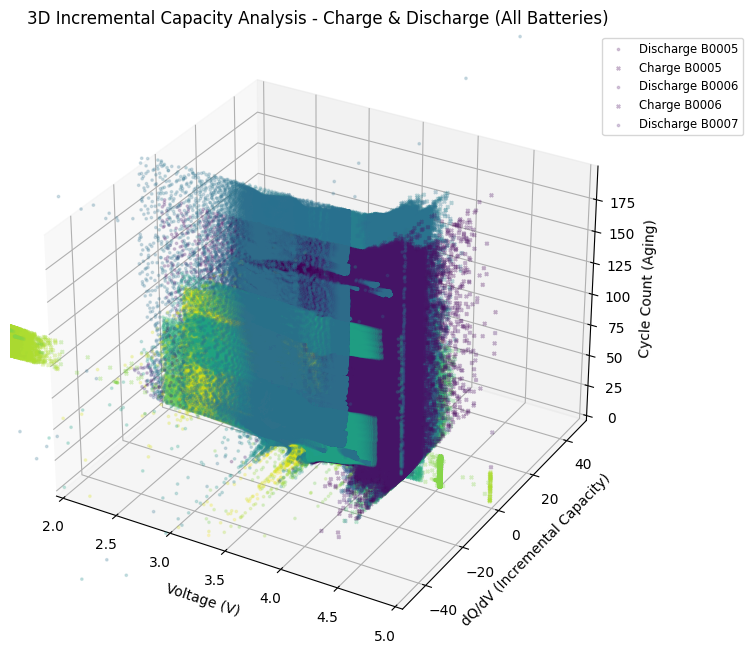

In [32]:
# Get unique battery IDs
battery_ids = df_discharge["battery_id"].unique()
colors = cm.viridis(np.linspace(0, 1, len(battery_ids)))  

# Create 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Loop through all batteries and plot together
for i, battery_id in enumerate(battery_ids):
    df_discharge_sample = df_discharge[df_discharge["battery_id"] == battery_id]
    df_charge_sample = df_charge[df_charge["battery_id"] == battery_id]

    # Plot discharge cycles
    ax.scatter(df_discharge_sample["Voltage_measured"], df_discharge_sample["dQ/dV"], df_discharge_sample["cycle_count"], 
               color=colors[i], label=f"Discharge {battery_id}", s=3, alpha=0.2)

    # Plot charge cycles (now with assigned cycle counts)
    ax.scatter(df_charge_sample["Voltage_measured"], df_charge_sample["dQ/dV"], df_charge_sample["cycle_count"], 
               color=colors[i], marker="x", label=f"Charge {battery_id}", s=6, alpha=0.3)  # Bigger size & more visible

# Labels
ax.set_xlabel("Voltage (V)")
ax.set_ylabel("dQ/dV (Incremental Capacity)")
ax.set_zlabel("Cycle Count (Aging)")
ax.set_title("3D Incremental Capacity Analysis - Charge & Discharge (All Batteries)")

# Adjust axes for better scaling
ax.set_xlim(2, 5)  # Adjust voltage range
ax.set_ylim(-50, 50)  # Focus on meaningful dQ/dV range
ax.set_zlim(0, df_discharge["cycle_count"].max())  # Dynamically scale cycle count

# Simplify Legend: Show only first 5 battery IDs
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:5], labels[:5], loc="upper right", fontsize="small", ncol=1, bbox_to_anchor=(1.2, 1))

# Show the plot
plt.show()


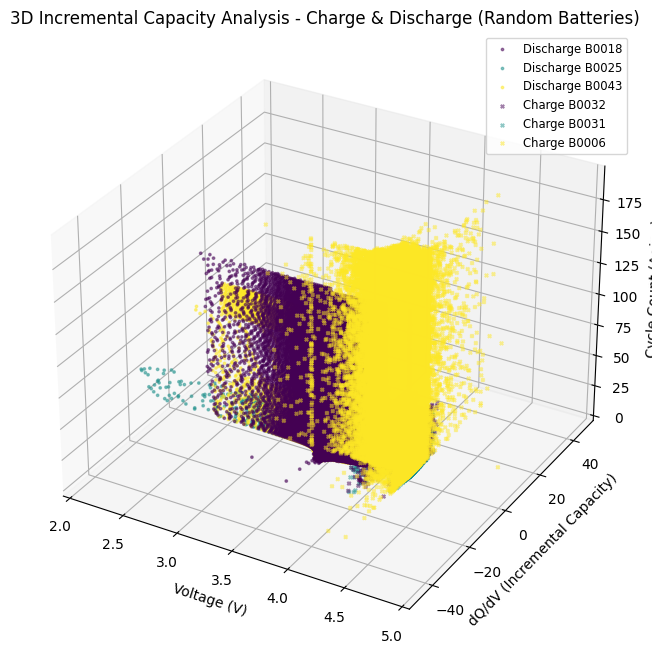

In [33]:

# Select 3 random batteries for discharge and charge
random_discharge_batteries = np.random.choice(df_discharge["battery_id"].unique(), 3, replace=False)
random_charge_batteries = np.random.choice(df_charge["battery_id"].unique(), 3, replace=False)

# Assign unique colors
colors = cm.viridis(np.linspace(0, 1, 3))

# Create 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Loop through selected batteries
for i, battery_id in enumerate(random_discharge_batteries):
    df_discharge_sample = df_discharge[df_discharge["battery_id"] == battery_id]
    ax.scatter(df_discharge_sample["Voltage_measured"], df_discharge_sample["dQ/dV"], df_discharge_sample["cycle_count"], 
               color=colors[i], label=f"Discharge {battery_id}", s=3, alpha=0.5)

for i, battery_id in enumerate(random_charge_batteries):
    df_charge_sample = df_charge[df_charge["battery_id"] == battery_id]
    ax.scatter(df_charge_sample["Voltage_measured"], df_charge_sample["dQ/dV"], df_charge_sample["cycle_count"], 
               color=colors[i], marker="x", label=f"Charge {battery_id}", s=6, alpha=0.5)  # Charge with 'x' markers

# Labels
ax.set_xlabel("Voltage (V)")
ax.set_ylabel("dQ/dV (Incremental Capacity)")
ax.set_zlabel("Cycle Count (Aging)")
ax.set_title("3D Incremental Capacity Analysis - Charge & Discharge (Random Batteries)")

# Adjust axes for better scaling
ax.set_xlim(2, 5)  
ax.set_ylim(-50, 50)  
ax.set_zlim(0, df_discharge["cycle_count"].max())  

# Add legend
ax.legend(loc="upper right", fontsize="small", ncol=1)

# Show the plot
plt.show()


In [40]:
df_impedance.columns

Index(['Sense_current', 'Battery_current', 'Current_ratio',
       'Battery_impedance', 'Rectified_Impedance', 'filename', 'battery_id',
       'type', 'cycle_count', 'Re(Z)', 'Im(Z)'],
      dtype='object')

In [41]:
df_impedance_final = df_impedance[["battery_id", "cycle_count","type","Re(Z)", "Im(Z)"]]


In [42]:
df_impedance_final.columns

Index(['battery_id', 'cycle_count', 'type', 'Re(Z)', 'Im(Z)'], dtype='object')

In [43]:
df_impedance.shape

(93888, 11)

In [44]:
df_impedance_final['type'].unique()

array(['impedance'], dtype=object)

In [45]:

df_merged = pd.merge(df_final, df_impedance[['battery_id', 'cycle_count', 'Re(Z)', 'Im(Z)', 'type']],
                     on=['battery_id', 'cycle_count'],
                     how='left',  # Keep all rows from df_final
                     suffixes=('_final', '_impedance'))  # Handle duplicate column names


df_merged['type'] = df_merged['type_final'].fillna(df_merged['type_impedance'])
df_merged.drop(columns=['type_final', 'type_impedance'], inplace=True)




df_merged[['Re(Z)', 'Im(Z)']] = df_merged[['Re(Z)', 'Im(Z)']].fillna(0)


# --- Display the merged DataFrame ---
print(df_merged.head())
print(df_merged.isnull().sum())


  battery_id  cycle_count          start_time  Voltage_measured  \
0      B0005          1.0 2008-04-02 15:25:41          4.190749   
1      B0005          1.0 2008-04-02 15:25:41          4.190749   
2      B0005          1.0 2008-04-02 15:25:41          4.190749   
3      B0005          1.0 2008-04-02 15:25:41          4.190749   
4      B0005          1.0 2008-04-02 15:25:41          4.190749   

   diff_capacity     dQ/dV  ambient_temperature            capacity     Re(Z)  \
0      -0.000007 -0.009276                   24  1.8564874208181574  0.057499   
1      -0.000007 -0.009276                   24  1.8564874208181574  0.071499   
2      -0.000007 -0.009276                   24  1.8564874208181574  0.063891   
3      -0.000007 -0.009276                   24  1.8564874208181574  0.056404   
4      -0.000007 -0.009276                   24  1.8564874208181574  0.056963   

      Im(Z)       type  
0  0.001034  discharge  
1  0.001041  discharge  
2  0.002042  discharge  
3  0.00107

In [47]:
df_merged["type"].nunique()

2

In [ ]:

df_merged = df_merged.dropna(subset=["cycle_count"])

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
import warnings

In [ ]:
X =df_merged.drop(columns=['cycle_count','start_time'],axis=1)

In [ ]:
X.shape

In [ ]:
y=df_merged['cycle_count']

In [ ]:
X.head()

In [ ]:
y.head()

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Identify numeric & categorical columns
num_features = X.select_dtypes(exclude=["object"]).columns
cat_features = X.select_dtypes(include=["object"]).columns

# Define One-Hot Encoder
oh_transformer = OneHotEncoder(handle_unknown="ignore")  

# Corrected ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[  # Fix: Wrap in list []
        ("onehot", oh_transformer, cat_features) 
    ]
)

# Apply transformation
X= preprocessor.fit_transform(X)


In [319]:
X.shape

(24611805, 2787)

In [311]:
# separate dataset into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train.shape, X_test.shape

((19689444, 2787), (4922361, 2787))

In [312]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

In [313]:
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(), 
    "AdaBoost Regressor": AdaBoostRegressor()
}
model_list = []
r2_list =[]

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train) # Train model

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Evaluate Train and Test dataset
    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)

    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)

    
    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    r2_list.append(model_test_r2)
    print('='*35)
    print('\n')

KeyboardInterrupt: 